# CIFAR-10 Convolutional neural network

Exercise - Load data
---

> **Exercise**: Load the CIFAR-10 data. Normalize the images and split them into train, validation and test sets. Define a `get_batches(X, y, batch_size)` function to generate random X/y batches of size `batch_size` using a Python generator.

In [1]:
import numpy as np
import os

# Load data
with np.load("c4_cifar10-6k.npz", allow_pickle=False) as npz_file:
    cifar = dict(npz_file.items())

# Convert pixels into floating point numbers
data = cifar["data"].astype(np.float32)

# Rescale pixel values between -0.5 and 0.5
data = (data - 128) / 255

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create train set
X_train, X_test, y_train, y_test = train_test_split(
    # Reshape images: 32 by 32 with 3 (RGB) color channels
    data.reshape(-1, 32, 32, 3),
    cifar["labels"],
    test_size=2000,
    random_state=0,
)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=1000, random_state=0
)

print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (4000, 32, 32, 3) (4000,)
Valid: (1000, 32, 32, 3) (1000,)
Test: (1000, 32, 32, 3) (1000,)


In [3]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y))  # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i : i + batch_size]
        yield X[batch_idx], y[batch_idx]

Exercise - Create and train a ConvNet
---

> **Exercise:** Create a convolutional neural network and train it using your batch generator. Evaluate the accuracy on the validation set after each epoch. Test different architectures and parameters. Evaluate your best network on the test set. Save the trained kernel weights of the first convolutional layer in a variable.

In [5]:
import tensorflow as tf

# Define the layers

# Convolutional layer
conv_layer = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding="SAME",
    activation=tf.nn.relu,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=0),
    name="conv",  # Add name
)

# Max pooling layer
pool_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="SAME")

# 2nd convolutional layer
conv_layer2 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="SAME",
    activation=tf.nn.relu,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=0),
    name="conv2",
)

# Flatten layer
flat_layer = tf.keras.layers.Flatten()

# Dropout layer
dropout_layer = tf.keras.layers.Dropout(rate=0.25, seed=0, name="dropout")

# Fully connected layer
fc_layer = tf.keras.layers.Dense(
    units=256,
    activation=tf.nn.relu,  # 256 hidden units
    kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2, seed=0),
    bias_initializer=tf.zeros_initializer(),
    name="dense",
)

# Output layer
logits_layer = tf.keras.layers.Dense(
    units=10,
    activation=None,  # No activation function
    kernel_initializer=tf.keras.initializers.VarianceScaling(scale=1, seed=0),
    bias_initializer=tf.zeros_initializer(),
    name="dense",
)

In [6]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define functions used to train the graph

# Compute the logits
@tf.function
def compute_logits(x, training):
    conv_output = conv_layer(x)
    pool_output = pool_layer(conv_output)
    conv_output2 = conv_layer2(pool_output)
    pool_output2 = pool_layer(conv_output2)
    flat_output = flat_layer(pool_output2)
    dropout_output = dropout_layer(flat_output, training=training)
    fc_output = fc_layer(dropout_output)
    logits_output = logits_layer(fc_output)
    return logits_output


# Compute the loss
@tf.function
def compute_loss(y, logits):
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_ce = tf.reduce_mean(ce)
    return mean_ce


# Compute the accuracy
@tf.function
def compute_accuracy(y, logits):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    return acc


# Train the model (optimization procedure)
@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        logits = compute_logits(x, training=True)
        loss = compute_loss(y, logits)
    # Concatenate the tarainable variables in one list usint the '+' operation on lists
    variables = (
        conv_layer.trainable_variables
        + conv_layer2.trainable_variables
        + fc_layer.trainable_variables
        + logits_layer.trainable_variables
    )

    optimizer.minimize(loss=loss, var_list=variables, tape=tape)
    return logits, loss

In [7]:
# Validation accuracy
valid_acc_values = []

# Set seed
np.random.seed(0)

# Train several epochs
for epoch in range(15):
    # Accuracy values (train) after each batch
    batch_acc = []

    # Get batches of data
    for X_batch, y_batch in get_batches(X_train, y_train, 64):
        # Run training
        batch_logits, _ = train(X_batch, y_batch)

        # Evaluate training accuracy (on current batch)
        acc = compute_accuracy(y_batch, batch_logits)
        batch_acc.append(acc)

    # Evaluate validation accuracy (on the whole data)
    valid_logits = compute_logits(X_valid, training=False)
    valid_acc = compute_accuracy(y_valid, valid_logits)
    valid_acc_values.append(valid_acc)

    # Print progress
    print(
        "Epoch {} - valid: {:.3f} train: {:.3f} (mean)".format(
            epoch + 1, valid_acc, np.mean(batch_acc)
        )
    )

# Get 1st conv. layer kernels
kernels = conv_layer.kernel

# Evaluate test accuracy after training
test_logits = compute_logits(X_test, training=False)
test_acc = compute_accuracy(y_test, test_logits)
print("Test accuracy: {:.3f}".format(test_acc))

2024-11-09 21:01:55.491448: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1 - valid: 0.288 train: 0.218 (mean)
Epoch 2 - valid: 0.367 train: 0.339 (mean)
Epoch 3 - valid: 0.378 train: 0.399 (mean)
Epoch 4 - valid: 0.402 train: 0.430 (mean)
Epoch 5 - valid: 0.437 train: 0.468 (mean)
Epoch 6 - valid: 0.456 train: 0.494 (mean)
Epoch 7 - valid: 0.469 train: 0.507 (mean)
Epoch 8 - valid: 0.487 train: 0.534 (mean)
Epoch 9 - valid: 0.492 train: 0.538 (mean)
Epoch 10 - valid: 0.495 train: 0.561 (mean)
Epoch 11 - valid: 0.500 train: 0.583 (mean)
Epoch 12 - valid: 0.495 train: 0.601 (mean)
Epoch 13 - valid: 0.507 train: 0.623 (mean)
Epoch 14 - valid: 0.515 train: 0.648 (mean)
Epoch 15 - valid: 0.515 train: 0.656 (mean)
Test accuracy: 0.534


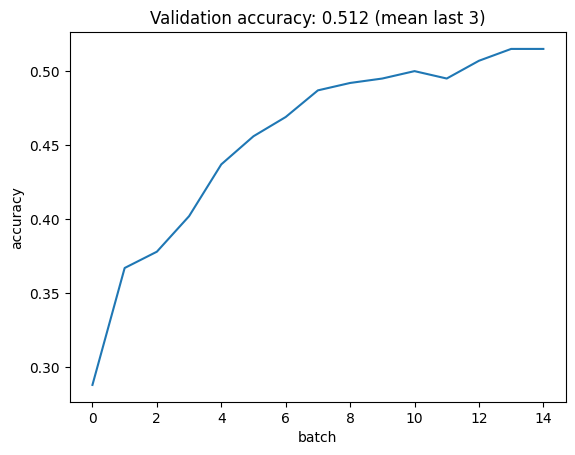

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title(
    "Validation accuracy: {:.3f} (mean last 3)".format(
        np.mean(valid_acc_values[-3:])  # last three values
    )
)
plt.xlabel("batch")
plt.ylabel("accuracy")
plt.show()

Exercise - Visualize kernels
---

> **Exercise**: Plot the kernels from the first convolutional layer with the `imshow()` function.

**Hint**: Remember that the `imshow()` function expects values between 0 and 1 for 3-dimensional arrays.

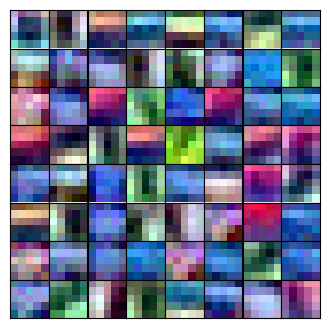

In [9]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(4, 4))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel = kernels[:, :, :, i].numpy().copy()

    # Rescale values between 0 and 1
    kernel -= kernel.min()  # Rescale between 0 and max
    kernel /= kernel.max()  # Rescale between 0 and 1

    # Plot kernel with imshow()
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False)  # disable x-axis
    axis.get_yaxis().set_visible(False)  # disable y-axis

plt.show()

Optional - Plot activation maps
---

> Pick an input image and plot the convolutional output of this image for each kernel to create, i.e. the **activation maps**.

**Hint**: The solution notebook from the previous unit shows already how this can be done for the MNIST dataset.

In [14]:
# Pick a sample image and get 1st conv. activations
activation_maps = conv_layer(np.expand_dims(X_valid[10], axis=0))

In [15]:
# Print shape of the variable
print("Activation maps:", activation_maps.shape)

Activation maps: (1, 16, 16, 64)


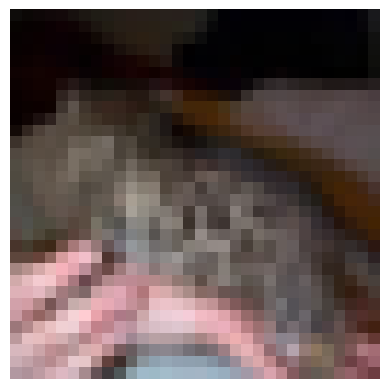

In [17]:
# Plot input image
img = X_valid[10]
img -= img.min()
img /= img.max()
plt.imshow(img)
plt.axis("off")
plt.show()

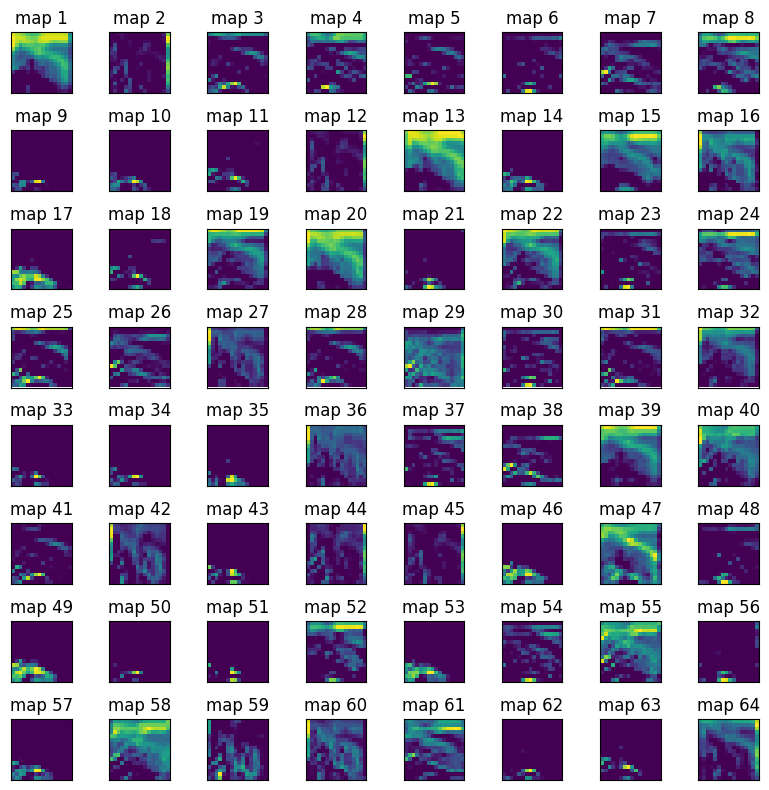

In [18]:
# Create figure with subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Plot the activation maps of the 1st conv. layer for the sample image
for i, axis in enumerate(axes.flatten()):
    # Get activation map of the i-th filter
    activation = activation_maps[0, :, :, i]

    # Plot it with imshow()
    axis.set_title("map {}".format(i + 1))
    axis.imshow(activation)
    axis.get_xaxis().set_visible(False)  # disable x-axis
    axis.get_yaxis().set_visible(False)  # disable y-axis

plt.tight_layout()
plt.show()